In [143]:
# Goal: Data preprocessing, NLP, topic models, spatialization/visualization of ERI publications and funded projects
# Load libraries
import re
from pprint import pprint
import pandas as pd
import numpy as np

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# pre-processing model (lemmatization) from spacy (en) and nltk
import spacy

# plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

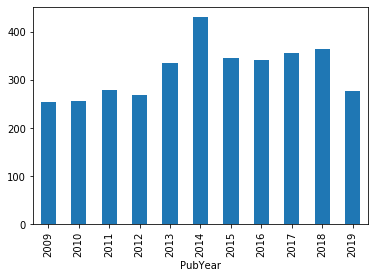

In [97]:
# DATA Read in pubs from csv; report distribution across publication years
pubs = pd.read_csv("ERI-publications-2009-2019.csv")
len(pubs)
pubs.head()
pubs.groupby(['PubYear']).size().plot(kind='bar')
#print(pubs.groupby(['PubYear']).size())

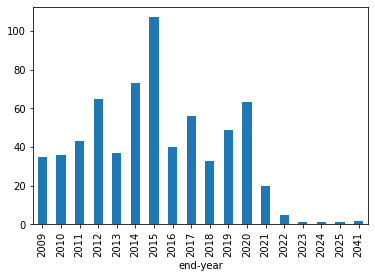

In [92]:
# DATA Read in projects from csv; report distribution across start and end years
proj = pd.read_csv("ERI-projects-2009-2019.csv")
len(proj)
proj.head()
#proj.groupby(['start-year']).size().plot(kind='bar')
proj.groupby(['end-year']).size().plot(kind='bar')
#print(proj.groupby(['end-year']).size())

In [76]:
# DATA Read in docs (corpus) from csv; report length of abstract text
docs = pd.read_csv("ERI-combined-2009-2019.csv")
len(docs)

# Concatenate title and abstract to new column for topic model
docs['combined'] = docs['title'].astype(str) + ' ' + docs['abstract'].astype(str)
docs.head()

# Calculate lengths of combined title and abstract; add columns to dataframe for length of abstracts
docs['title_len'] = docs['title'].apply(len)
docs['abstract_len'] = docs['abstract'].apply(len)
docs['combined_len'] = docs['combined'].apply(len)
docs.head()

# Calculate summary statistics for combined title and abstract lengths to determine text suitability
docs.combined_len.describe()

count    3770.000000
mean     1678.432626
std       687.609548
min       128.000000
25%      1247.000000
50%      1630.000000
75%      1993.000000
max      7083.000000
Name: combined_len, dtype: float64

In [108]:
# DATA Title and abstract to list, removing new line characters, quotations
#docs.head()
data = docs['combined'].values.tolist()
data = [re.sub('\s+', ' ', sent) for sent in data] #remove new line characters
data = [re.sub("\'", "", sent) for sent in data] #remove single quotes
pprint(data[:1])

['Streams and Urbanization Urbanization encompasses a diverse array of '
 'watershed alterations that influence the physical, chemical, and biological '
 'characteristics of streams. In this chapter, we summarize lessons learned '
 'from the last half century of research on urban streams and provide a '
 'critique of various mitigation strategies, including recent approaches that '
 'explicitly address geomorphic processes. We focus first on the abiotic '
 'conditions (primarily hydrologic and geomorphic) and their changes in '
 'streams that accompany urbanization, recognizing that these changes may vary '
 'with geomorphic context and climatic region. We then discuss technical '
 'approaches and limitations to (1) mitigating water-quantity and '
 'water-quality degradation through site design, riparian protection, and '
 'structural stormwater-management strategies; and (2) restoring urban streams '
 'in those watersheds where the economic, social, and political contexts can '
 'supp

In [100]:
# NLP Load stopwords from NLTK, extend default list with custom stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['data', 'study', 'project', 'research', 'collaborative'])

In [155]:
# NLP Tokenize each sentence into a list of lowercase words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True remove punctuation

data_words = list(sent_to_words(data))

print(data_words[:1])

[['streams', 'and', 'urbanization', 'urbanization', 'encompasses', 'diverse', 'array', 'of', 'watershed', 'alterations', 'that', 'influence', 'the', 'physical', 'chemical', 'and', 'biological', 'characteristics', 'of', 'streams', 'in', 'this', 'chapter', 'we', 'summarize', 'lessons', 'learned', 'from', 'the', 'last', 'half', 'century', 'of', 'research', 'on', 'urban', 'streams', 'and', 'provide', 'critique', 'of', 'various', 'mitigation', 'strategies', 'including', 'recent', 'approaches', 'that', 'explicitly', 'address', 'geomorphic', 'processes', 'we', 'focus', 'first', 'on', 'the', 'abiotic', 'conditions', 'primarily', 'hydrologic', 'and', 'geomorphic', 'and', 'their', 'changes', 'in', 'streams', 'that', 'accompany', 'urbanization', 'recognizing', 'that', 'these', 'changes', 'may', 'vary', 'with', 'geomorphic', 'context', 'and', 'climatic', 'region', 'we', 'then', 'discuss', 'technical', 'approaches', 'and', 'limitations', 'to', 'mitigating', 'water', 'quantity', 'and', 'water', 'qua

In [137]:
# NLP Bigram and trigram models (words frequently occurring together in the doc)
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=80) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=80)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See bigram example (given a specific record)
print(trigram_mod[bigram_mod[data_words[1]]])

['evidence', 'for', 'widespread', 'creep', 'on', 'the', 'flanks', 'of', 'the', 'sea', 'of', 'marmara', 'transform', 'basin', 'from', 'marine', 'geophysical', 'data', 'wave', 'fields', 'have', 'long', 'been', 'recognized', 'in', 'marine', 'sediments', 'on', 'the', 'flanks', 'of', 'basins', 'and', 'oceans', 'in', 'both', 'tectonically_active', 'and', 'inactive', 'environments', 'the', 'origin', 'of', 'waves', 'hereafter', 'called', 'undulations', 'is', 'controversial', 'competing', 'models', 'ascribe', 'them', 'to', 'depositional', 'processes', 'gravity', 'driven', 'downslope', 'creep', 'or', 'collapse', 'and', 'or', 'tectonic', 'shortening', 'here', 'we', 'analyze', 'pervasive', 'undulation', 'fields', 'identified', 'in', 'swath', 'bathymetry', 'and', 'new', 'high', 'resolution', 'multichannel_seismic', 'mcs', 'reflection', 'data', 'from', 'the', 'sea', 'of', 'marmara', 'turkey', 'although', 'they', 'exhibit', 'some', 'of', 'the', 'classical', 'features', 'of', 'sediment', 'waves', 'the

In [138]:
# NLP Define functions for stopwords, bigrams, trigrams, and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [158]:
# NLP Remove stopwords, make bigrams, make trigrams, and lemmatize
data_words_nostops = remove_stopwords(data_words) # stop words
data_words_bigrams = make_bigrams(data_words_nostops) # bigrams
data_words_trigrams = make_trigrams(data_words_bigrams) # trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['stream', 'urbanization', 'urbanization', 'encompass', 'diverse', 'array', 'watershed', 'alteration', 'influence', 'physical', 'chemical', 'biological', 'characteristic', 'stream', 'chapter', 'summarize', 'lessons_learn', 'last', 'half', 'century', 'urban', 'stream', 'provide', 'critique', 'various', 'mitigation', 'strategy', 'include', 'recent', 'approach', 'explicitly', 'address', 'geomorphic', 'process', 'focus', 'first', 'abiotic', 'condition', 'primarily', 'hydrologic', 'geomorphic', 'change', 'stream', 'accompany', 'urbanization', 'recognize', 'change', 'may', 'vary', 'geomorphic', 'context', 'climatic', 'region', 'discuss', 'technical', 'approach', 'limitation', 'mitigate', 'water', 'quantity', 'water', 'quality', 'degradation', 'site', 'design', 'riparian', 'protection', 'structural', 'stormwater', 'management', 'strategy', 'restore', 'urban', 'stream', 'watershed', 'economic', 'social', 'political', 'context', 'support', 'activity']]


In [163]:
# NLP Create dictionary and corpus for topic modeling
# Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View corpus based on term-frequency
#print(corpus[:1])
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Save dictionary and corpus for future use - optional
#import pickle
#pickle.dump(corpus, open('corpus.pkl', 'wb'))
#id2word.save('dictionary.gensim')

[[('abiotic', 1),
  ('accompany', 1),
  ('activity', 1),
  ('address', 1),
  ('alteration', 1),
  ('approach', 2),
  ('array', 1),
  ('biological', 1),
  ('century', 1),
  ('change', 2),
  ('chapter', 1),
  ('characteristic', 1),
  ('chemical', 1),
  ('climatic', 1),
  ('condition', 1),
  ('context', 2),
  ('critique', 1),
  ('degradation', 1),
  ('design', 1),
  ('discuss', 1),
  ('diverse', 1),
  ('economic', 1),
  ('encompass', 1),
  ('explicitly', 1),
  ('first', 1),
  ('focus', 1),
  ('geomorphic', 3),
  ('half', 1),
  ('hydrologic', 1),
  ('include', 1),
  ('influence', 1),
  ('last', 1),
  ('lessons_learn', 1),
  ('limitation', 1),
  ('management', 1),
  ('may', 1),
  ('mitigate', 1),
  ('mitigation', 1),
  ('physical', 1),
  ('political', 1),
  ('primarily', 1),
  ('process', 1),
  ('protection', 1),
  ('provide', 1),
  ('quality', 1),
  ('quantity', 1),
  ('recent', 1),
  ('recognize', 1),
  ('region', 1),
  ('restore', 1),
  ('riparian', 1),
  ('site', 1),
  ('social', 1),
  

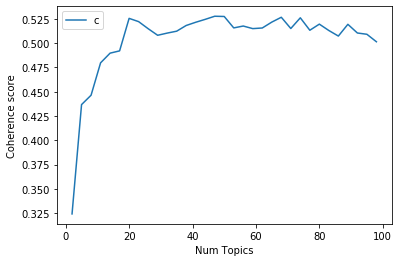

In [164]:
# TOPIC MODELING (LDA) Find optimal number of topics for LDA (up to limit) 
# TO DO: experiment with optimize interval values (10)
# Approach: build many LDA models with different topic numbers (k); find the one with the highest coherence value
# Goal: choose an inflection point (k) that marks the end of a rapid growth of topic coherence

mallet_path = 'mallet-2.0.8/bin/mallet' # path to Mallet file in same directory
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=3)

# Show graph
limit=100; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [165]:
# TOPIC MODELING (LDA) Print the coherence scores from the previous run; select highest score (47 topics)
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3243
Num Topics = 5  has Coherence Value of 0.4368
Num Topics = 8  has Coherence Value of 0.4465
Num Topics = 11  has Coherence Value of 0.4798
Num Topics = 14  has Coherence Value of 0.4898
Num Topics = 17  has Coherence Value of 0.4921
Num Topics = 20  has Coherence Value of 0.5256
Num Topics = 23  has Coherence Value of 0.5222
Num Topics = 26  has Coherence Value of 0.5149
Num Topics = 29  has Coherence Value of 0.5082
Num Topics = 32  has Coherence Value of 0.5104
Num Topics = 35  has Coherence Value of 0.5124
Num Topics = 38  has Coherence Value of 0.5182
Num Topics = 41  has Coherence Value of 0.5215
Num Topics = 44  has Coherence Value of 0.5245
Num Topics = 47  has Coherence Value of 0.5277
Num Topics = 50  has Coherence Value of 0.5275
Num Topics = 53  has Coherence Value of 0.5157
Num Topics = 56  has Coherence Value of 0.5177
Num Topics = 59  has Coherence Value of 0.515
Num Topics = 62  has Coherence Value of 0.5157
Num Topics = 65  

In [170]:
# TOPIC MODELING (LDA) Build the model with 47 topics
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, 
                                             corpus=corpus, 
                                             id2word=id2word, 
                                             num_topics=47,
                                             #optimize_interval=10, #TO DO: experiment with hyperparameter
                                             random_seed=1)

# Show topics - optional
pprint(ldamallet.show_topics(formatted=False))

# Compute coherence score, verify that it is the same as in the previous run (higher is better)
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(40,
  '0.027*"resource" + 0.025*"management" + 0.022*"risk" + 0.019*"policy" + '
  '0.017*"environmental" + 0.017*"human" + 0.015*"strategy" + '
  '0.015*"development" + 0.013*"adaptation" + 0.013*"social"'),
 (11,
  '0.061*"river" + 0.040*"flow" + 0.040*"channel" + 0.037*"stream" + '
  '0.035*"sediment" + 0.027*"watershed" + 0.023*"flood" + 0.022*"floodplain" + '
  '0.019*"discharge" + 0.015*"downstream"'),
 (25,
  '0.345*"model" + 0.030*"predict" + 0.021*"simulation" + 0.021*"base" + '
  '0.020*"parameter" + 0.019*"develop" + 0.018*"uncertainty" + '
  '0.018*"simulate" + 0.016*"prediction" + 0.014*"modeling"'),
 (39,
  '0.039*"impact" + 0.031*"environmental" + 0.029*"production" + '
  '0.026*"energy" + 0.017*"technology" + 0.014*"product" + 0.013*"potential" + '
  '0.011*"reduce" + 0.011*"demand" + 0.010*"system"'),
 (29,
  '0.053*"area" + 0.035*"land_use" + 0.033*"conservation" + 0.028*"habitat" + '
  '0.028*"urban" + 0.027*"land" + 0.020*"crop" + 0.019*"biodiversity" + '
  '0.019

In [179]:
# TOPIC MODELING (LDA) Dominant topic for each document
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get dominant topic for each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the dominant topic, percent contribution, and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)
#df_dominant_topic.to_csv('LDA-47-top-doc.csv') #save out to csv

In [181]:
# TOPIC MODELING (LDA) Most representative document for each topic
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet
#sent_topics_sorteddf_mallet.to_csv('LDA-47-rep-doc.csv') #save out to csv

In [182]:
# TOPIC MODELING (LDA) Topic distribution across documents
# Number of documents for each topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of documents for each topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic number and keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate columns
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics
#df_dominant_topics.to_csv('LDA-47-top-dist.csv') #save out to csv

In [173]:
# TOPIC MODELING (LDA) Convert the class of the Mallet model into a LdaModel, show in pyLDAvis, save graph as html
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
pyLDAvis.save_html(vis, 'lda.html') #save pyLDAvis graphs as standalone webpage
vis

/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/saralafia/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
37    -0.200900  0.107185       1        1  2.591503
19     0.055895 -0.249393       2        1  2.453624
26    -0.122156  0.073416       3        1  2.450294
35     0.093358 -0.027069       4        1  2.444235
25     0.139997  0.097054       5        1  2.425111
0     -0.110048 -0.004655       6        1  2.392598
40     0.175352 -0.079728       7        1  2.387494
13     0.210184  0.133589       8        1  2.351045
7     -0.181165  0.096142       9        1  2.334778
42     0.000291 -0.158237      10        1  2.326019
43     0.142601  0.086646      11        1  2.305927
46     0.151442  0.155939      12        1  2.286960
39     0.145992 -0.077432      13        1  2.285329
14    -0.040926 -0.173090      14        1  2.280489
30    -0.075686 -0.028702      15        1  2.255870
3      0.014770 -0.193575      16        1  2.245540
2     -0.033766  0.036210      17        1  2.234580
41    -0.181371  0.037253      18        1  2.231731
5     -0.200813  0.127808      19        1  2.183669
38    -0.048368 -0.074128      20        1  2.177443
20    -0.097564 -0.191842      21        1  2.176023
4     -0.068015  0.034763      22        1  2.171251
15    -0.001137 -0.108857      23        1  2.156883
11    -0.088037  0.016512      24        1  2.094733
18     0.124014  0.152408      25        1  2.080608
12    -0.026257  0.047090      26        1  2.076003
45    -0.046585  0.096883      27        1  2.074545
16    -0.020982 -0.060806      28        1  2.069253
9     -0.186325  0.070865      29        1  2.061954
44     0.157853 -0.096829      30        1  2.045374
23     0.160803  0.050571      31        1  2.038327
28     0.153175  0.169990      32        1  2.037345
17    -0.069903  0.091791      33        1  2.019377
36     0.015291 -0.117419      34        1  2.018084
1     -0.013175 -0.032955      35        1  2.011117
6     -0.057451 -0.023735      36        1  2.004231
29     0.070816 -0.137284      37        1  1.992146
33    -0.020339  0.015613      38        1  1.876312
31    -0.102280  0.005423      39        1  1.864988
22    -0.007589  0.053114      40        1  1.860119
32     0.006356 -0.136311      41        1  1.855297
24     0.135511  0.069266      42        1  1.849403
8     -0.025459  0.015041      43        1  1.823006
21     0.008358  0.126688      44        1  1.821658
27     0.062038 -0.074556      45        1  1.813153
34     0.108381  0.099574      46        1  1.734776
10    -0.106178 -0.020232      47        1  1.729794, topic_info=      Category         Freq            Term        Total  loglift  logprob
121    Default  4392.000000           model  4392.000000  30.0000  30.0000
64     Default  2862.000000           water  2862.000000  29.0000  29.0000
109    Default  2866.000000            high  2866.000000  28.0000  28.0000
9      Default  2412.000000          change  2412.000000  27.0000  27.0000
112    Default  2195.000000        increase  2195.000000  26.0000  26.0000
911    Default  1370.000000            soil  1370.000000  25.0000  25.0000
784    Default  1622.000000           scale  1622.000000  24.0000  24.0000
138    Default  1308.000000         spatial  1308.000000  23.0000  23.0000
228    Default  1703.000000          specie  1703.000000  22.0000  22.0000
337    Default  1407.000000         climate  1407.000000  21.0000  21.0000
581    Default  1492.000000             low  1492.000000  20.0000  20.0000
51     Default  1057.000000            site  1057.000000  19.0000  19.0000
1220   Default  1138.000000     temperature  1138.000000  18.0000  18.0000
41     Default  1651.000000         process  1651.000000  17.0000  17.0000
262    Default  1666.000000          effect  1666.000000  16.0000  16.0000
5      Default  1056.000000        approach  1056.000000  15.0000  15.0000
713    Default   881.000000            snow   881.000000  14.0000  14.0000
643    Def

In [ ]:
# VISUALIZATION (LDA) Frequency distribution of word counts in documents
